<a href="https://colab.research.google.com/github/Uppala19/Airline-fare-Prediction/blob/main/final_project_msc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [229]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import holidays  # For marking holiday flights

import requests
import time


Load and Explore the Dataset

In [230]:
# Load dataset
file_path = '/content/Data_Train (3).xlsx' # Replace with your dataset path
data = pd.read_excel(file_path)

Size of data set

In [231]:
data.shape

(10683, 11)

Inspect the dataset

In [232]:
data.head(3)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882


In [233]:
data.iloc[-2:]  # Retrieves the last 5 rows


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648
10682,Air India,9/05/2019,Delhi,Cochin,DEL → GOI → BOM → COK,10:55,19:15,8h 20m,2 stops,No info,11753


#information about the data

In [234]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [235]:
print(data.columns)


Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')


In [236]:
data.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


Check for missing values

In [237]:
data.isnull().sum()

,0
Airline,0
Date_of_Journey,0
Source,0
Destination,0
Route,1
Dep_Time,0
Arrival_Time,0
Duration,0
Total_Stops,1
Additional_Info,0


Adding some neccesary data fields to already existing excel data set

In [238]:
pip install pandas openpyxl geopy requests datetime holidays


In [239]:
data = pd.read_excel(file_path,engine='openpyxl')

Add Cabin Class

In [240]:
cabin_classes = ['Economy', 'Business', 'First Class']
data['Cabin_Class'] = np.random.choice(cabin_classes, size=len(data))

Extract Layover Information from Route

In [241]:
def get_layover(route):
    stops = route.count('→')  # Assuming route format like 'City1 → City2 → City3'
    return stops, "Direct" if stops == 0 else f"{stops} Stop(s)"

data[['Number_of_Stops', 'Flight_Layover']] = data['Route'].apply(lambda x: pd.Series(get_layover(str(x))))

Calculate Days Until Departure

In [242]:
data['Date_of_Journey'] = pd.to_datetime(data['Date_of_Journey'], format='%d/%m/%Y')
#Generate random booking dates (For real case, replace with actual data)
data['Booking_Date'] = data['Date_of_Journey'] - pd.to_timedelta(np.random.randint(1, 60, size=len(data)), unit='D')
#Compute days until departure
data['Days_Until_Departure'] = (data['Date_of_Journey'] - data['Booking_Date']).dt.days


 fetching holidays in 2019

In [243]:
  import requests
  import pandas as pd

  # Replace with your actual API key from Calendarific
  API_KEY = "NGcTjMSkwkZd1LT0ltkzOf9UdY0EzJ2k"

  # Define the API endpoint for fetching holidays in 2019
  url = f"https://calendarific.com/api/v2/holidays?api_key={API_KEY}&country=IN&year=2019"

  # Make the API request
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      holidays_data = response.json()

      # Extract holiday details
      holidays_list = holidays_data.get("response", {}).get("holidays", [])

      # Display the holiday details
      print(f"Airline Holidays for 2019 in India:\n")
      holiday_dates = []
      for holiday in holidays_list:
          holiday_date = holiday["date"]["iso"][:10] # Extract only the date part (YYYY-MM-DD)
          holiday_name = holiday["name"]
          holiday_type = holiday["type"]
          holiday_dates.append(holiday_date)
        # print(f"Date: {holiday_date} | Name: {holiday_name} | Type: {holiday_type}")

  else:
      print(f"Error: Unable to fetch holiday data (Status Code: {response.status_code})")

Airline Holidays for 2019 in India:



 Mark Holiday Season Flights

In [244]:
    # Convert holiday dates to datetime format for comparison
    holiday_dates = pd.to_datetime(holiday_dates, format='%Y-%m-%d') # Specify the format

    # Mark flights as part of the holiday season (1 if holiday, 0 if not)
    data['Is_Holiday_Season'] = data['Date_of_Journey'].isin(holiday_dates).astype(int)
    #print(data)

Off-Peak Season Flag

In [245]:
# Function to determine if the flight is in the peak season
def is_peak_season(row):
    # Define peak_months here
    peak_months = [12, 1, 2, 3, 4]  # Example: December to April are peak months

    # Check if the flight date is during a holiday or in peak months
    if row['Date_of_Journey'] in holiday_dates or row['Date_of_Journey'].month in peak_months:
        return 1  # Peak season
    return 0  # Non-peak season

# Apply the function to create the 'Is_Peak_Season' column
data['Is_Peak_Season'] = data.apply(is_peak_season, axis=1)
# Now, let's analyze fare prices during peak season vs non-peak season
peak_fares = data[data['Is_Peak_Season'] == 1]['Price']
non_peak_fares = data[data['Is_Peak_Season'] == 0]['Price']
# Calculate average fare for peak and non-peak season
average_peak_fare = peak_fares.mean()
average_non_peak_fare = non_peak_fares.mean()

#print(f"Average fare during peak season: {average_peak_fare}")
#print(f"Average fare during non-peak season: {average_non_peak_fare}")
#print(data)

adding Fuel price by using API  once check

In [246]:
#import requests
#import pandas as pd

# Replace with your actual API key
API_KEY = "f695fbbb339ef3304ccefdd7091f56debe745901584075b65ef83213eba85aaf"

# Define the URL for the API request (this is just an example)
url = f"https://api.oilpriceapi.com/v1/prices?api_key={API_KEY}&start_date=2019-01-01&end_date=2019-12-31"
# Make the API request to get the latest fuel prices
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
  #Parse the response JSON
  fuel_data = response.json()

     # Extract the fuel prices from the response
  fuel_prices = pd.DataFrame(fuel_data['data'], columns=['date', 'price'])
  fuel_prices['date'] = pd.to_datetime(fuel_prices['date'])  # Convert to datetime



    # Merge the fuel prices with flight data based on the 'Date_of_Journey'
  data = data.merge(fuel_prices, left_on='Date_of_Journey', right_on='date', how='left')

    # Rename the 'price' column to 'Fuel_Price'
  data.rename(columns={'price': 'Fuel_Price'}, inplace=True)

    # Drop the 'date' column after merge
  data.drop(['date'], axis=1, inplace=True)

    # Display the merged data
  print(data)
else:
    print(f"Error: Unable to fetch fuel prices (Status Code: {response.status_code})")
#print(data)


Error: Unable to fetch fuel prices (Status Code: 401)


Adding Simulated Data to oil Prices

In [247]:
# Set random seed for reproducibility
np.random.seed(42)
fuel_price_data = pd.DataFrame({
    'Date': pd.date_range(start='2019-01-01', periods=365, freq='D'),
    'Fuel_Price_INR': np.random.uniform(60000, 90000, size=365)  # ATF price in INR per kiloliter

})

# Merge fuel prices with dataset
fuel_price_data['Date'] = pd.to_datetime(fuel_price_data['Date'])
data = data.merge(fuel_price_data, left_on='Booking_Date', right_on='Date', how='left', suffixes=('', '_fuel'))
data.rename(columns={'Fuel_Price_INR': 'ATF_Price_INR'}, inplace=True)
data.drop(columns=['Date'], inplace=True)
#print(data)

In [248]:
print(data.head(5))

       Airline Date_of_Journey    Source Destination                  Route  \
0       IndiGo      2019-03-24  Banglore   New Delhi              BLR → DEL   
1    Air India      2019-05-01   Kolkata    Banglore  CCU → IXR → BBI → BLR   
2  Jet Airways      2019-06-09     Delhi      Cochin  DEL → LKO → BOM → COK   
3       IndiGo      2019-05-12   Kolkata    Banglore        CCU → NAG → BLR   
4       IndiGo      2019-03-01  Banglore   New Delhi        BLR → NAG → DEL   

  Dep_Time  Arrival_Time Duration Total_Stops Additional_Info  Price  \
0    22:20  01:10 22 Mar   2h 50m    non-stop         No info   3897   
1    05:50         13:15   7h 25m     2 stops         No info   7662   
2    09:25  04:25 10 Jun      19h     2 stops         No info  13882   
3    18:05         23:30   5h 25m      1 stop         No info   6218   
4    16:50         21:35   4h 45m      1 stop         No info  13302   

   Cabin_Class  Number_of_Stops Flight_Layover Booking_Date  \
0     Business               

In [249]:

data.to_excel("Updated_Flight_Fare_Data.xlsx", index=False, engine='openpyxl')

print("✅ Updated dataset saved successfully!")

✅ Updated dataset saved successfully!


save an updated file in Google Colab

In [250]:
# Assuming the updated data is in a DataFrame called 'data'
data.to_csv('/content/updated_file.csv', index=False)


In [251]:
#Fetch all Columns
data.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price', 'Cabin_Class', 'Number_of_Stops',
       'Flight_Layover', 'Booking_Date', 'Days_Until_Departure',
       'Is_Holiday_Season', 'Is_Peak_Season', 'ATF_Price_INR'],
      dtype='object')

In [252]:
data.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Cabin_Class,Number_of_Stops,Flight_Layover,Booking_Date,Days_Until_Departure,Is_Holiday_Season,Is_Peak_Season,ATF_Price_INR
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,Business,1,1 Stop(s),2019-02-05,47,0,1,84251.920443
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,Economy,3,3 Stop(s),2019-03-26,36,1,1,69329.469651


Data Analysis And Visualization on train dataSet

In [253]:
#to extract names of airlines from the data
unique_airlines = pd.unique(data["Airline"])
print(unique_airlines)


['IndiGo' 'Air India' 'Jet Airways' 'SpiceJet' 'Multiple carriers' 'GoAir'
 'Vistara' 'Air Asia' 'Vistara Premium economy' 'Jet Airways Business'
 'Multiple carriers Premium economy' 'Trujet']


In [254]:
#Iterate through each column in the DataFrame and print the number of unique values in that column
for i in data:
    print(f"Number of unique values in {i} -->> {data[i].nunique()}")

Number of unique values in Airline -->> 12
Number of unique values in Date_of_Journey -->> 40
Number of unique values in Source -->> 5
Number of unique values in Destination -->> 6
Number of unique values in Route -->> 128
Number of unique values in Dep_Time -->> 222
Number of unique values in Arrival_Time -->> 1343
Number of unique values in Duration -->> 368
Number of unique values in Total_Stops -->> 5
Number of unique values in Additional_Info -->> 10
Number of unique values in Price -->> 1870
Number of unique values in Cabin_Class -->> 3
Number of unique values in Number_of_Stops -->> 6
Number of unique values in Flight_Layover -->> 6
Number of unique values in Booking_Date -->> 177
Number of unique values in Days_Until_Departure -->> 59
Number of unique values in Is_Holiday_Season -->> 2
Number of unique values in Is_Peak_Season -->> 2
Number of unique values in ATF_Price_INR -->> 177


In [255]:
#Print the count of each unique value in every column
for i in data:
    print(data[i].value_counts())

Airline
Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: count, dtype: int64
Date_of_Journey
2019-05-18    504
2019-06-06    503
2019-05-21    497
2019-06-09    495
2019-06-12    493
2019-05-09    484
2019-03-21    423
2019-05-15    405
2019-03-06    403
2019-05-27    382
2019-06-27    355
2019-06-24    351
2019-06-01    342
2019-06-03    333
2019-06-15    328
2019-03-24    323
2019-03-03    315
2019-03-09    302
2019-03-27    299
2019-05-24    286
2019-05-06    282
2019-05-01    277
2019-05-12    259
2019-04-01    257
2019-03-01    

 Visualisation of how do Layovers Affect Flight Prices by scatter plot

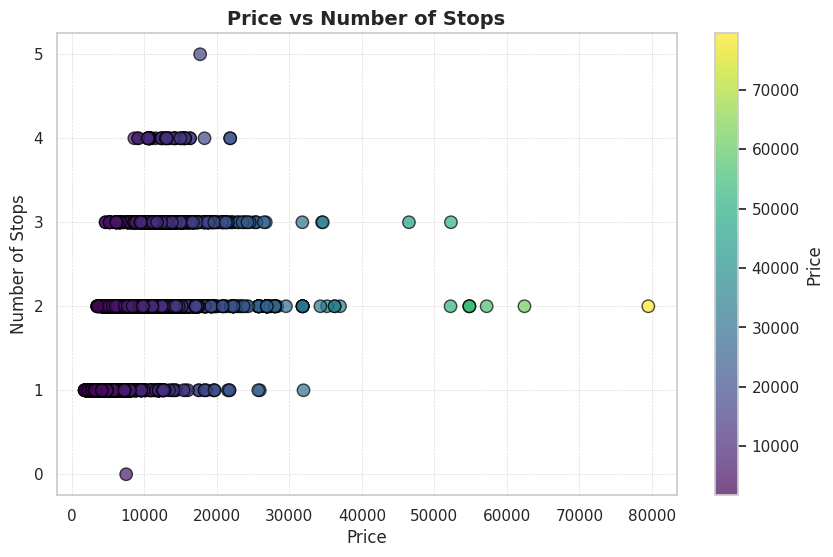

In [256]:
import matplotlib.pyplot as plt

# Create a scatter plot with customized aesthetics
plt.figure(figsize=(10, 6))

# Use a color map to represent the data more beautifully
plt.scatter(data['Price'], data['Number_of_Stops'], s=80, alpha=0.7, c=data['Price'], cmap='viridis', edgecolors='black')

# Add a color bar to indicate the price scale
plt.colorbar(label='Price')

# Customize plot title and labels
plt.title('Price vs Number of Stops', fontsize=14, fontweight='bold')
plt.xlabel('Price', fontsize=12)
plt.ylabel('Number of Stops', fontsize=12)

# Add grid lines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
# Show the plot
plt.show()


Distribution of Flights Across Airlines ✈️

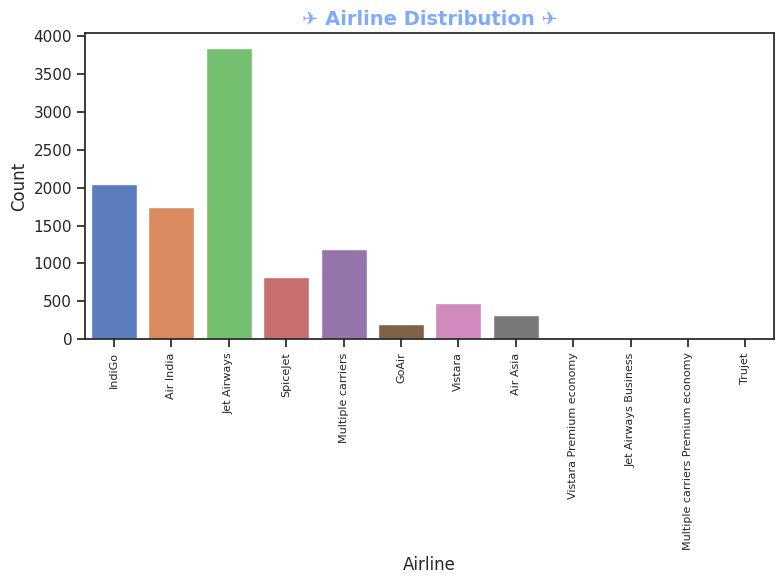

In [257]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a nice style
sns.set(style="ticks")

# Create the countplot with a color palette
plt.figure(figsize=(8, 6))
sns.countplot(x="Airline", data=data, hue="Airline",palette="muted",legend=False)


# Title and labels with styling
plt.title("✈️ Airline Distribution ✈️", fontweight="bold", fontsize=14, color="#80aaff")
plt.xlabel("Airline")
plt.ylabel("Count")

# Rotate x-tick labels for better readability
plt.xticks(rotation=90, fontsize=8)

# Show the plot
plt.tight_layout()
plt.show()


Visualizing how ticket fares vary across different airlines over the journey dates



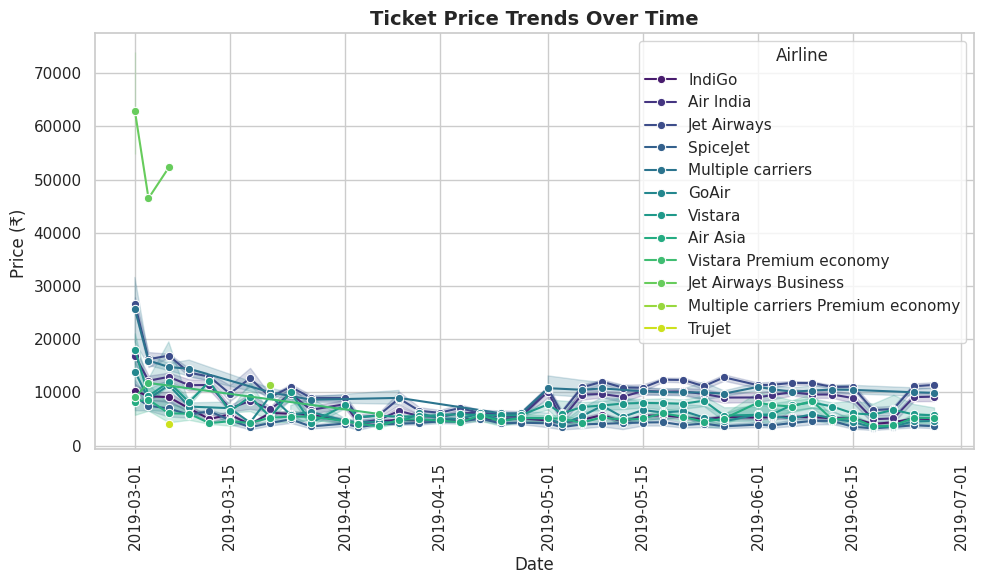

In [258]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set(style="whitegrid")

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x="Date_of_Journey", y="Price", data=data, hue="Airline", marker="o", palette="viridis") # Changed x to "Date_of_Journey" and y to "Price"

# Add title and labels
plt.title("Ticket Price Trends Over Time", fontsize=14, fontweight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (₹) ", fontsize=12)
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()


The distribution of bookings as the departure date approaches.

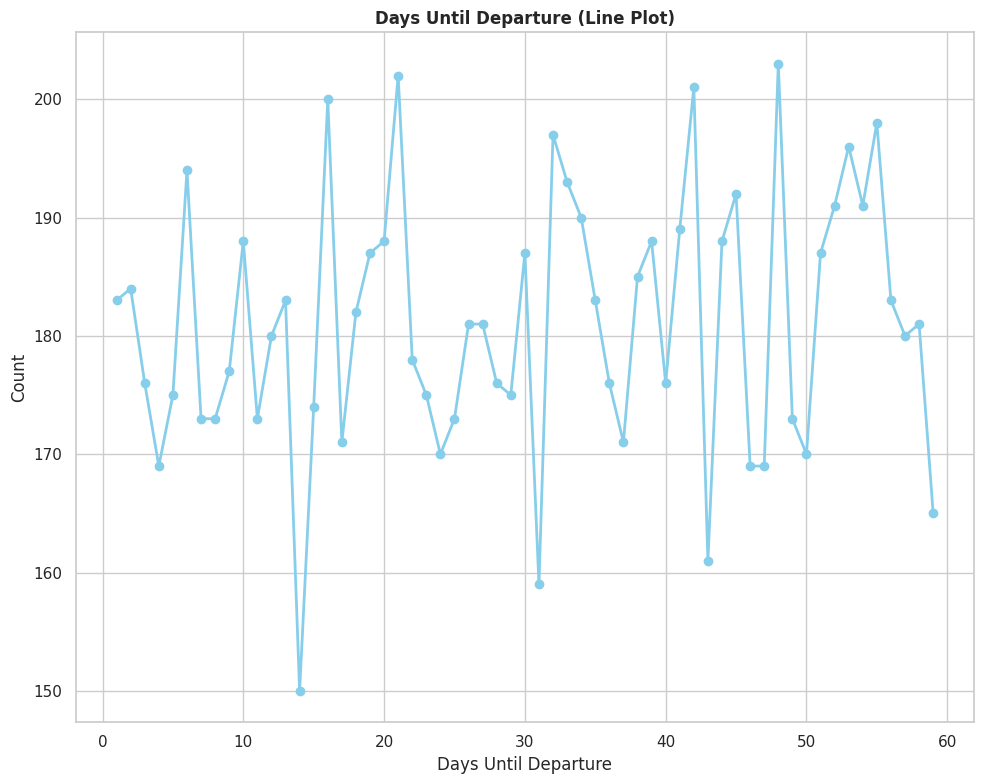

In [259]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'Days_Until_Departure' is in your data, we first calculate the frequency of each unique value
days_count = data['Days_Until_Departure'].value_counts().sort_index()

# Create a line plot for 'Days_Until_Departure'
plt.figure(figsize=(10,8))
plt.plot(days_count.index, days_count.values, marker='o', color='skyblue', linewidth=2)

# Add title and labels
plt.title('Days Until Departure (Line Plot)', fontsize=12, fontweight='bold')
plt.xlabel('Days Until Departure', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Remove top and right spines for a clean look
#plt.gca().spines[['top', 'right']].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()


Should keep this graph in last it would be better

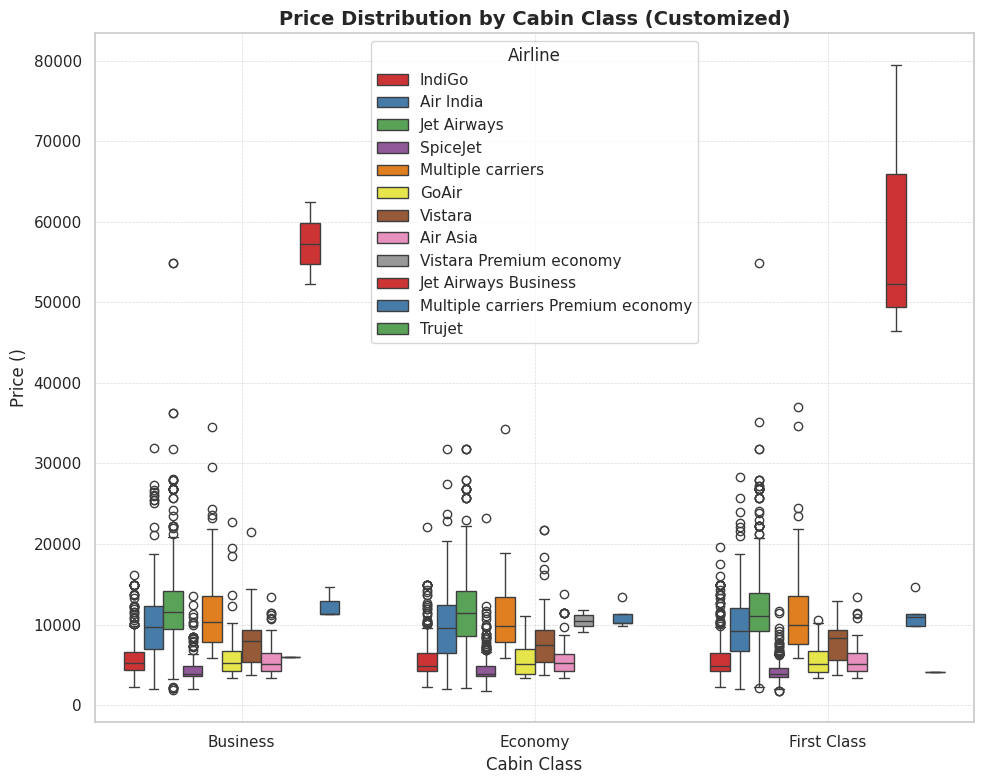

In [260]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set(style="whitegrid")

# Create a boxplot with hue for another variable (e.g., Flight Type)
plt.figure(figsize=(10, 8))
#sns.boxplot(x="Cabin_Class", y="Price", data=data, palette=["#3498db", "#e74c3c"], hue="Airline")
sns.boxplot(x="Cabin_Class", y="Price", data=data, palette="Set1",hue="Airline")

# Customize title, labels, and grid lines
plt.title("Price Distribution by Cabin Class (Customized)", fontsize=14, fontweight='bold')
plt.xlabel("Cabin Class", fontsize=12)
plt.ylabel("Price ()", fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


 Visualisation of Price Distribution by Cabin Class

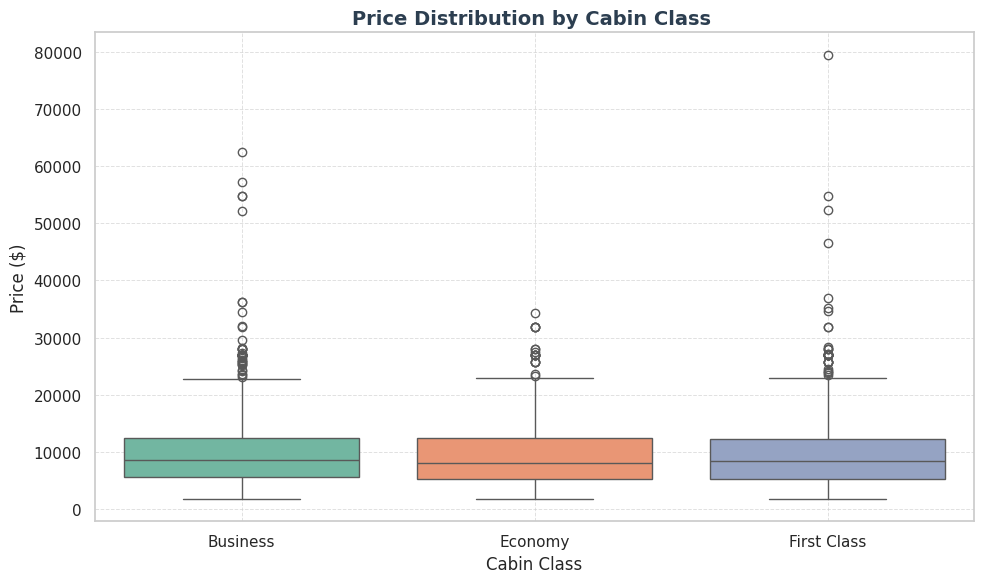

In [261]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style for a clean, modern look
sns.set(style="whitegrid")

# Create the boxplot for Cabin Class vs Price
plt.figure(figsize=(10, 6))
sns.boxplot(x="Cabin_Class", y="Price", data=data, palette="Set2",hue ="Cabin_Class" )

# Customize title, labels, and grid lines
plt.title("Price Distribution by Cabin Class ", fontsize=14, fontweight='bold', color="#2c3e50")
plt.xlabel("Cabin Class", fontsize=12)
plt.ylabel("Price ($)", fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()


  Visualisation of Airline Price Distribution

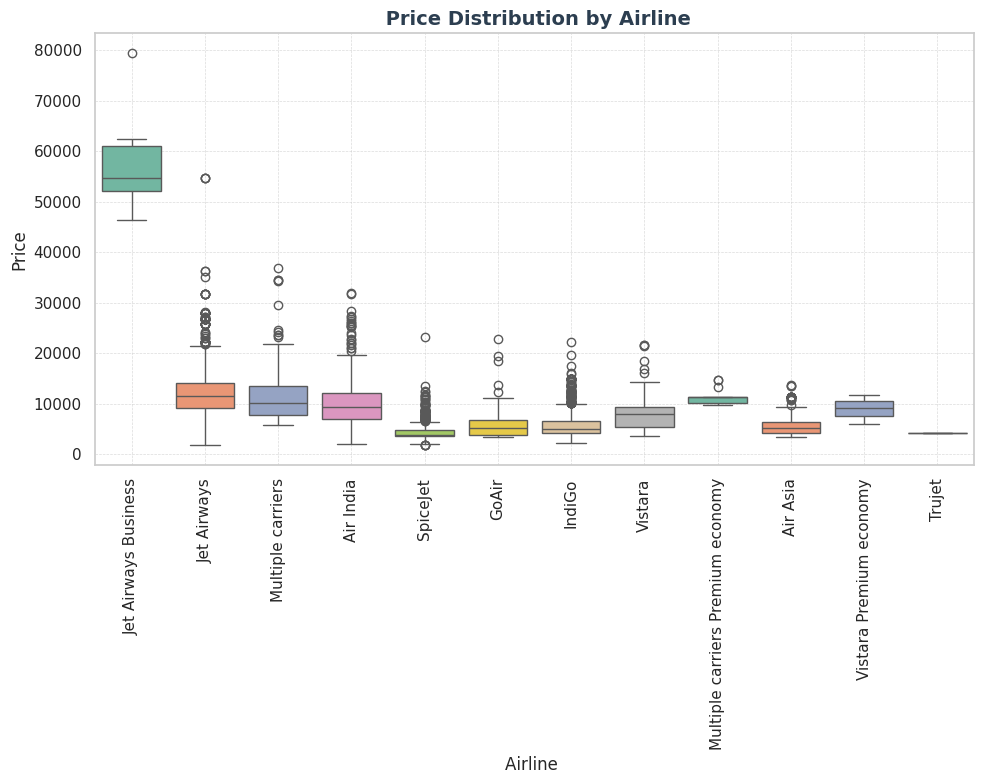

In [262]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style for a clean, modern look
sns.set(style="whitegrid")

# Create the boxplot
plt.figure(figsize=(10, 8))
sns.boxplot(x="Airline", y="Price", data=data.sort_values('Price', ascending=False), hue="Airline",palette="Set2")

# Customize title, labels, and grid lines with emojis
plt.title(" Price Distribution by Airline", fontsize=14, fontweight='bold', color="#2c3e50")
plt.xlabel("Airline ", fontsize=12)
plt.ylabel("Price", fontsize=12)

# Rotate x-axis labels for better readability
#plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xticks(rotation = 90)

# Remove top and right spines for a cleaner look
#sns.despine()

# Add grid lines for readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


Visualizing the Correlation Matrix of Flight Fare Dataset

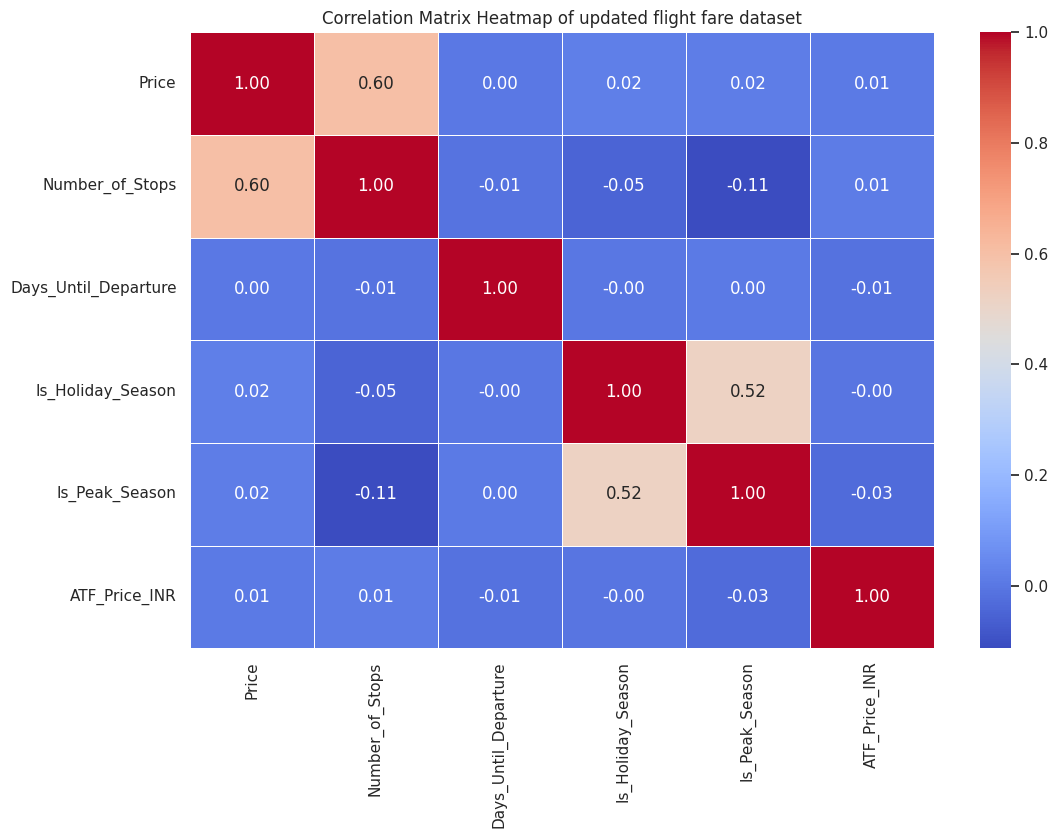

In [263]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = "Updated_Flight_Fare_Data.xlsx"  # Update with your correct file path
data = pd.read_excel(file_path)

# Compute the correlation matrix
corr_matrix = data.corr(numeric_only=True)  # Ensures only numeric columns are considered

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap of updated flight fare dataset")
plt.show()


In [264]:
 #Top 10 used Routes and visualize using barplot

most_used_routes = data["Route"].value_counts().sort_values(ascending = False)[:10]
most_used_routes

,count
Route,
DEL → BOM → COK,2376
BLR → DEL,1552
CCU → BOM → BLR,979
CCU → BLR,724
BOM → HYD,621
CCU → DEL → BLR,565
BLR → BOM → DEL,402
MAA → CCU,381
DEL → HYD → COK,326


visualisation of top 10 most used routes using bar plot

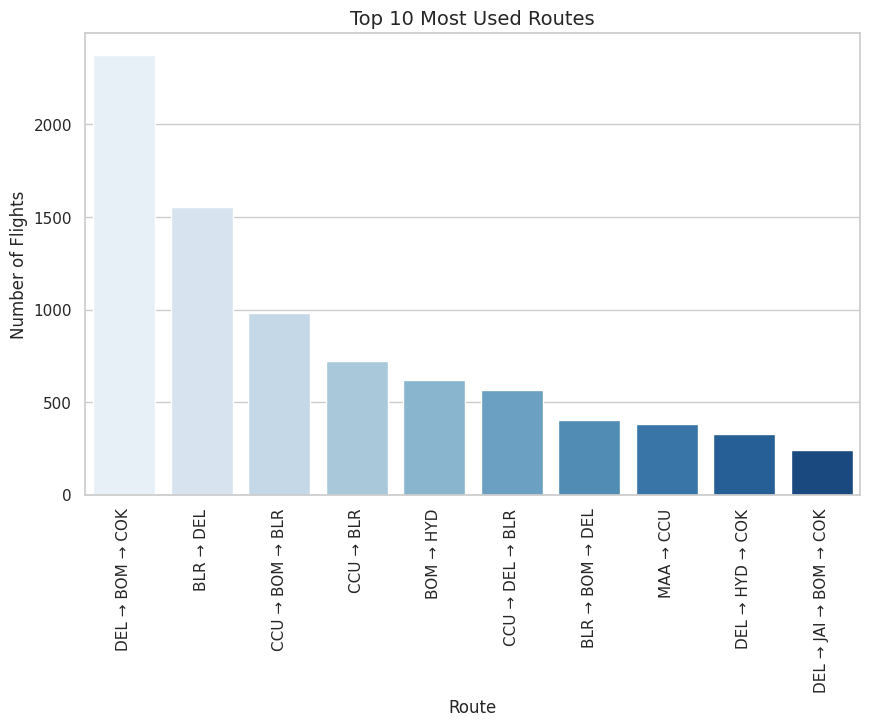

In [265]:
plt.figure(figsize=(10,6))
sns.barplot(x=most_used_routes.index, y=most_used_routes.values, palette="Blues",hue=most_used_routes.index)
# Customize the title and labels
plt.title('Top 10 Most Used Routes', fontsize=14)
plt.xlabel('Route', fontsize=12)
plt.ylabel('Number of Flights', fontsize=12)
#plt.xticks(rotation=45, ha="right")
plt.xticks(rotation=90)
plt.show()

 Impact of Fuel Price on Flight Price

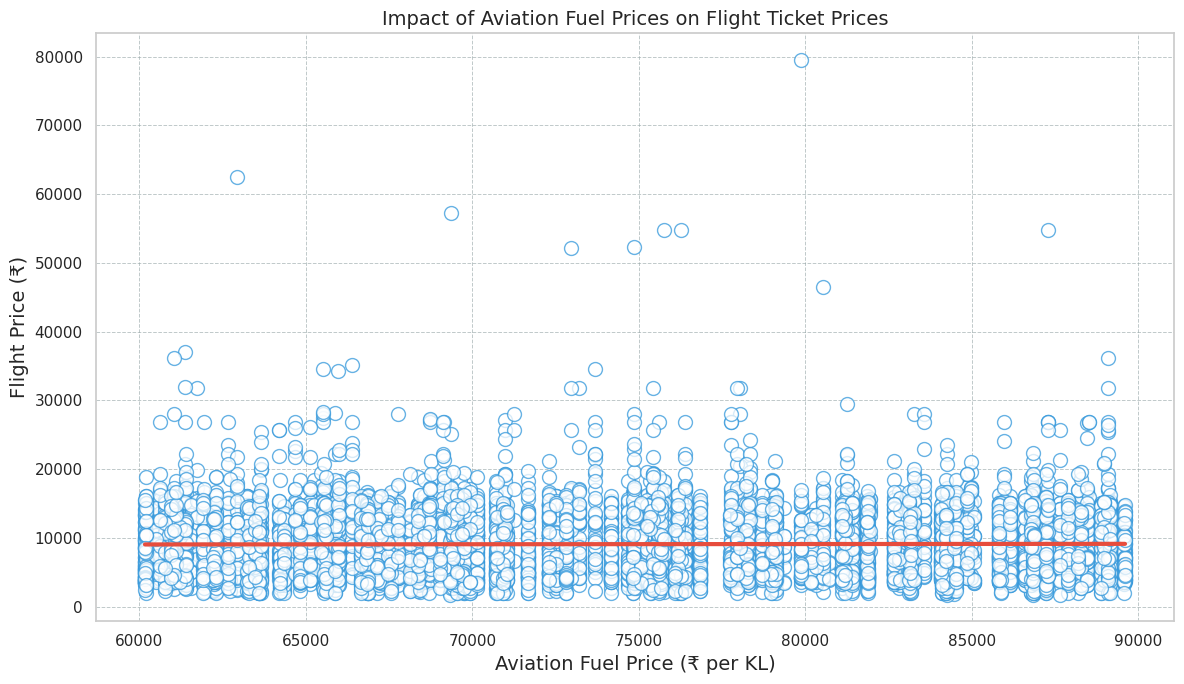

In [266]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set(style="whitegrid")

# Create figure
plt.figure(figsize=(12, 7))

# Define color palette
scatter_color = "#3498db"  # Blue
line_color = "#e74c3c"  # Red

# Create scatter plot with regression line
sns.regplot(
    x="ATF_Price_INR", y="Price", data=data, color=scatter_color,
    scatter_kws={"s": 100, "facecolors": "white", "edgecolor": scatter_color, "alpha": 0.75},
    line_kws={"color": line_color, "linewidth": 3}
)

# Customize title and labels
plt.title("Impact of Aviation Fuel Prices on Flight Ticket Prices", fontsize=14)
plt.xlabel("Aviation Fuel Price (₹ per KL)", fontsize=14)
plt.ylabel("Flight Price (₹)", fontsize=14)

# Grid styling
plt.grid(True, linestyle='dashed', linewidth=0.7, alpha=0.6, color="#95a5a6")

# Add annotation for trend insight
#plt.annotate("Higher fuel prices generally increase flight costs",
 #            xy=(data["ATF_Price_INR"].median(), data["Price"].median()),
  #           xytext=(data["ATF_Price_INR"].min()+5000, data["Price"].max()-5000),
   #          arrowprops=dict(arrowstyle="->", color="black", lw=1.5), fontsize=12, color="#2c3e50")

# Optimize layout
plt.tight_layout()

# Display the plot
plt.show()


Feature Engineering after updating the data set

In [267]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Airline               10683 non-null  object        
 1   Date_of_Journey       10683 non-null  datetime64[ns]
 2   Source                10683 non-null  object        
 3   Destination           10683 non-null  object        
 4   Route                 10682 non-null  object        
 5   Dep_Time              10683 non-null  object        
 6   Arrival_Time          10683 non-null  object        
 7   Duration              10683 non-null  object        
 8   Total_Stops           10682 non-null  object        
 9   Additional_Info       10683 non-null  object        
 10  Price                 10683 non-null  int64         
 11  Cabin_Class           10683 non-null  object        
 12  Number_of_Stops       10683 non-null  int64         
 13  Flight_Layover  

In [268]:
data.isnull().sum()

,0
Airline,0
Date_of_Journey,0
Source,0
Destination,0
Route,1
Dep_Time,0
Arrival_Time,0
Duration,0
Total_Stops,1
Additional_Info,0


In [269]:
## Display the data types of each column in the dataset
data.dtypes

,0
Airline,object
Date_of_Journey,datetime64[ns]
Source,object
Destination,object
Route,object
Dep_Time,object
Arrival_Time,object
Duration,object
Total_Stops,object
Additional_Info,object


In [270]:
# Retrieve the unique values present in the 'Date_of_Journey' column
data["Date_of_Journey"].unique()

<DatetimeArray>
['2019-03-24 00:00:00', '2019-05-01 00:00:00', '2019-06-09 00:00:00',
 '2019-05-12 00:00:00', '2019-03-01 00:00:00', '2019-06-24 00:00:00',
 '2019-03-12 00:00:00', '2019-05-27 00:00:00', '2019-06-01 00:00:00',
 '2019-04-18 00:00:00', '2019-05-09 00:00:00', '2019-04-24 00:00:00',
 '2019-03-03 00:00:00', '2019-04-15 00:00:00', '2019-06-12 00:00:00',
 '2019-03-06 00:00:00', '2019-03-21 00:00:00', '2019-04-03 00:00:00',
 '2019-05-06 00:00:00', '2019-05-15 00:00:00', '2019-06-18 00:00:00',
 '2019-06-15 00:00:00', '2019-04-06 00:00:00', '2019-05-18 00:00:00',
 '2019-06-27 00:00:00', '2019-05-21 00:00:00', '2019-06-03 00:00:00',
 '2019-03-15 00:00:00', '2019-05-03 00:00:00', '2019-03-09 00:00:00',
 '2019-06-06 00:00:00', '2019-05-24 00:00:00', '2019-04-01 00:00:00',
 '2019-04-21 00:00:00', '2019-06-21 00:00:00', '2019-03-27 00:00:00',
 '2019-03-18 00:00:00', '2019-04-12 00:00:00', '2019-04-09 00:00:00',
 '2019-04-27 00:00:00']
Length: 40, dtype: datetime64[ns]

In [271]:
# Ensure 'Date of Journey' is in datetime format
data['Date_of_Journey'] = pd.to_datetime(data['Date_of_Journey'])
#errors='coerce')

# Extract date components
data['Day'] = data['Date_of_Journey'].dt.day
data['Month'] = data['Date_of_Journey'].dt.month
data['Year'] = data['Date_of_Journey'].dt.year

print(data.head(2))
#droping the column is optional
data.drop("Date_of_Journey", inplace=True, axis=1)



     Airline Date_of_Journey    Source Destination                  Route  \
0     IndiGo      2019-03-24  Banglore   New Delhi              BLR → DEL   
1  Air India      2019-05-01   Kolkata    Banglore  CCU → IXR → BBI → BLR   

  Dep_Time  Arrival_Time Duration Total_Stops Additional_Info  Price  \
0    22:20  01:10 22 Mar   2h 50m    non-stop         No info   3897   
1    05:50         13:15   7h 25m     2 stops         No info   7662   

  Cabin_Class  Number_of_Stops Flight_Layover Booking_Date  \
0    Business                1      1 Stop(s)   2019-02-05   
1     Economy                3      3 Stop(s)   2019-03-26   

   Days_Until_Departure  Is_Holiday_Season  Is_Peak_Season  ATF_Price_INR  \
0                    47                  0               1   84251.920443   
1                    36                  1               1   69329.469651   

   Day  Month  Year  
0   24      3  2019  
1    1      5  2019  


 Function to extract hour and minute components from a datetime column


In [272]:
def extract_hour_min(data,col):
  # Ensure the column is in datetime format before using .dt accessor
    data[col] = pd.to_datetime(data[col])
    data[col+"_hour"]=data[col].dt.hour
    data[col+"_minute"]=data[col].dt.minute
    return data.head(2)

In [273]:
# Apply the extract_hour_min function to extract hour and minute from the 'Dep_Time' column

extract_hour_min(data, "Dep_Time")

<ipython-input-272-e34e52dae364>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col] = pd.to_datetime(data[col])


,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Cabin_Class,Number_of_Stops,Flight_Layover,Booking_Date,Days_Until_Departure,Is_Holiday_Season,Is_Peak_Season,ATF_Price_INR,Day,Month,Year,Dep_Time_hour,Dep_Time_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2025-03-18 22:20:00,01:10 22 Mar,2h 50m,non-stop,No info,3897,Business,1,1 Stop(s),2019-02-05,47,0,1,84251.920443,24,3,2019,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2025-03-18 05:50:00,13:15,7h 25m,2 stops,No info,7662,Economy,3,3 Stop(s),2019-03-26,36,1,1,69329.469651,1,5,2019,5,50


In [274]:
# Extract hour and minute from the 'Arrival_Time' column using the extract_hour_min function

extract_hour_min(data, "Arrival_Time")

<ipython-input-272-e34e52dae364>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col] = pd.to_datetime(data[col])


,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Cabin_Class,Number_of_Stops,Flight_Layover,Booking_Date,Days_Until_Departure,Is_Holiday_Season,Is_Peak_Season,ATF_Price_INR,Day,Month,Year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2025-03-18 22:20:00,2025-03-22 01:10:00,2h 50m,non-stop,No info,3897,Business,1,1 Stop(s),2019-02-05,47,0,1,84251.920443,24,3,2019,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2025-03-18 05:50:00,2025-03-18 13:15:00,7h 25m,2 stops,No info,7662,Economy,3,3 Stop(s),2019-03-26,36,1,1,69329.469651,1,5,2019,5,50,13,15


now we can drop the dep_time and arrival time as well

In [275]:
cols_to_drop =['Arrival_Time', 'Dep_Time']
data.drop(cols_to_drop, axis=1, inplace=True)

In [276]:
data.head(2)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Cabin_Class,Number_of_Stops,Flight_Layover,Booking_Date,Days_Until_Departure,Is_Holiday_Season,Is_Peak_Season,ATF_Price_INR,Day,Month,Year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,Business,1,1 Stop(s),2019-02-05,47,0,1,84251.920443,24,3,2019,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,Economy,3,3 Stop(s),2019-03-26,36,1,1,69329.469651,1,5,2019,5,50,13,15


In [277]:
data["Booking_Date"].unique()

<DatetimeArray>
['2019-02-05 00:00:00', '2019-03-26 00:00:00', '2019-04-14 00:00:00',
 '2019-05-09 00:00:00', '2019-02-23 00:00:00', '2019-05-31 00:00:00',
 '2019-03-09 00:00:00', '2019-02-18 00:00:00', '2019-02-10 00:00:00',
 '2019-04-18 00:00:00',
 ...
 '2019-06-07 00:00:00', '2019-03-10 00:00:00', '2019-01-05 00:00:00',
 '2019-06-19 00:00:00', '2019-01-23 00:00:00', '2019-06-17 00:00:00',
 '2019-01-01 00:00:00', '2019-06-25 00:00:00', '2019-06-26 00:00:00',
 '2019-01-02 00:00:00']
Length: 177, dtype: datetime64[ns]

Function to categorize flight departure time into different time slots based on the hour


In [278]:
def flight_dep_time(x):
    if (x > 4) and (x <= 8):
        return "Early Morning"
    elif (x > 8) and (x <= 12):
        return "Morning"
    elif (x > 12) and (x <= 16):
        return "Noon"
    elif (x > 16) and (x <= 20):
        return "Evening"
    elif (x > 20) and (x <= 24):
        return "Night"
    else:
        return "late night"  # Corrected indentation

Number of Flights Departing at Different Times

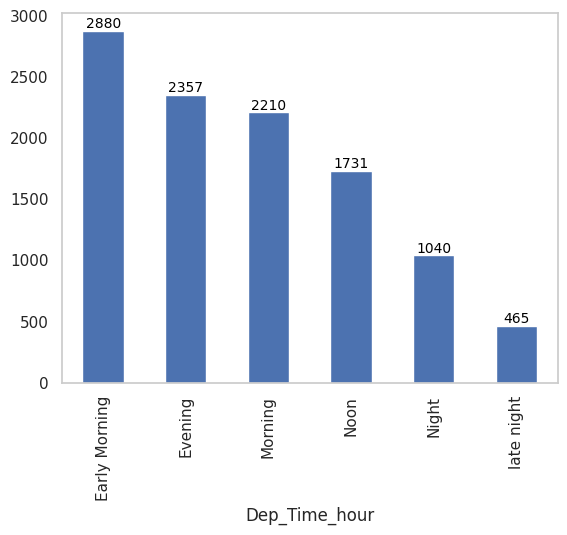

In [279]:
ax=data['Dep_Time_hour'].apply(flight_dep_time).value_counts().plot(kind="bar",color="b")
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            f'{bar.get_height()}', ha='center', va='bottom', fontsize=10, color='black')
ax.grid(False)  # Disables grid lines


In [280]:
data.head(2)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Cabin_Class,Number_of_Stops,Flight_Layover,Booking_Date,Days_Until_Departure,Is_Holiday_Season,Is_Peak_Season,ATF_Price_INR,Day,Month,Year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,Business,1,1 Stop(s),2019-02-05,47,0,1,84251.920443,24,3,2019,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,Economy,3,3 Stop(s),2019-03-26,36,1,1,69329.469651,1,5,2019,5,50,13,15


function adds '0h' if hours are missing, and '0m' if minutes are missing in the duration.


In [281]:
def prepocess_duration(x):
  if 'h' not in x:
      x = '0h'+' '+ x
  elif 'm' not in x:
      x = x + ' '+'0m'
  return x

In [282]:
# Applies the 'preprocess_duration' function to ensure the 'Duration' column has both hours and minutes.

data['Duration']=data['Duration'].apply(prepocess_duration)

In [283]:
data['Duration']

,Duration
0,2h 50m
1,7h 25m
2,19h 0m
3,5h 25m
4,4h 45m
...,...
10678,2h 30m
10679,2h 35m
10680,3h 0m
10681,2h 40m


 Extracts hours and minutes from the 'Duration' column, removes 'h' and 'm',
 and converts them into integers

In [284]:
data['Duration_hours'] = data['Duration'].str.split(' ').str[0].str.replace('h', '').astype(int)
data['Duration_minutes'] = data['Duration'].str.split(' ').str[1].str.replace('m', '').astype(int)

In [285]:
data.head(2)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Cabin_Class,Number_of_Stops,Flight_Layover,Booking_Date,Days_Until_Departure,Is_Holiday_Season,Is_Peak_Season,ATF_Price_INR,Day,Month,Year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_minutes
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,Business,1,1 Stop(s),2019-02-05,47,0,1,84251.920443,24,3,2019,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,Economy,3,3 Stop(s),2019-03-26,36,1,1,69329.469651,1,5,2019,5,50,13,15,7,25


In [286]:
# Converts the 'Duration' column into total minutes by multiplying hours by 60 and adding minutes.

data['Duration_total_mins']=data['Duration'].str.replace('h',"*60").str.replace(' ','+').str.replace('m' ,"*1").apply(eval)

Visualizing the Relationship Between Flight Duration, Price, and Total Stops

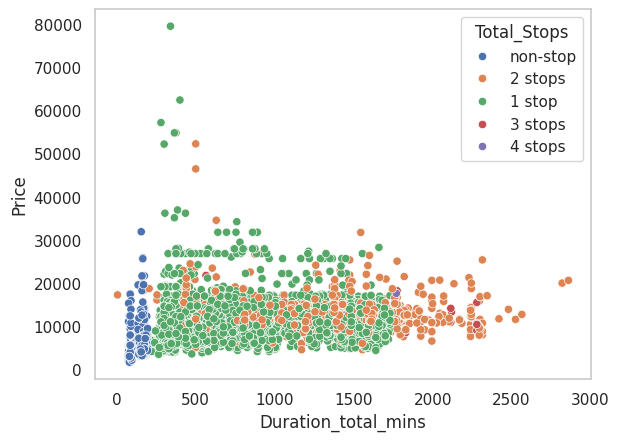

In [287]:
sns.scatterplot(x="Duration_total_mins" ,y= "Price", hue="Total_Stops" ,data=data)
# Remove grid lines
plt.grid(False)

Analyzing the Linear Relationship Between Flight Duration and Ticket Price

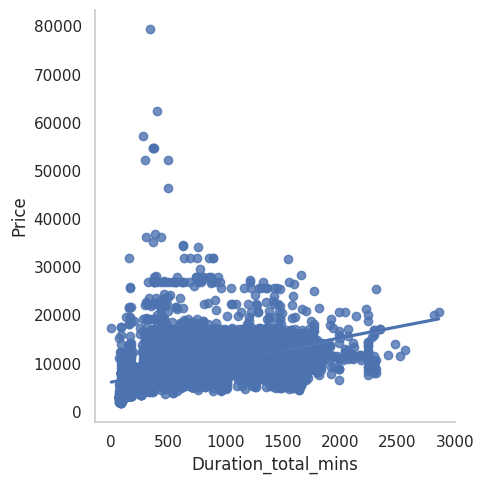

In [288]:
sns.lmplot(x="Duration_total_mins", y="Price", data=data)
# Remove grid lines
plt.grid(False)

Extracting Categorical Columns from a Dataset

In [289]:
Categorical_Column = []
for col in data.columns:
    if data[col].dtype == 'object':
        Categorical_Column.append(col)


In [290]:
print(Categorical_Column)


['Airline', 'Source', 'Destination', 'Route', 'Duration', 'Total_Stops', 'Additional_Info', 'Cabin_Class', 'Flight_Layover']


 Extracting numerical columns from the dataset

In [291]:
Numerical_column = []
for col in data.columns:
    if data[col].dtype != 'object':
        Numerical_column.append(col)


In [292]:
print(Numerical_column)


['Price', 'Number_of_Stops', 'Booking_Date', 'Days_Until_Departure', 'Is_Holiday_Season', 'Is_Peak_Season', 'ATF_Price_INR', 'Day', 'Month', 'Year', 'Dep_Time_hour', 'Dep_Time_minute', 'Arrival_Time_hour', 'Arrival_Time_minute', 'Duration_hours', 'Duration_minutes', 'Duration_total_mins']


In [293]:
#to obtain unique values present in the 'Source' column
data['Source'].unique()

array(['Banglore', 'Kolkata', 'Delhi', 'Chennai', 'Mumbai'], dtype=object)

In [294]:
# Iterate over each unique value in the 'Source' column to create dummy variables
for sub_category in data['Source'].unique():
#Create a new column for each unique 'Source' category, where 1 indicates the presence of the category, 0 otherwise
  data[f'Source_{sub_category}'] = (data['Source'] == sub_category).astype(int)


In [295]:
data.head(2)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Cabin_Class,Number_of_Stops,Flight_Layover,Booking_Date,Days_Until_Departure,Is_Holiday_Season,Is_Peak_Season,ATF_Price_INR,Day,Month,Year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_minutes,Duration_total_mins,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,Business,1,1 Stop(s),2019-02-05,47,0,1,84251.920443,24,3,2019,22,20,1,10,2,50,170,1,0,0,0,0
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,Economy,3,3 Stop(s),2019-03-26,36,1,1,69329.469651,1,5,2019,5,50,13,15,7,25,445,0,1,0,0,0


In [296]:
# calculate the average price for each airline and sort the results in ascending order
airlines = data.groupby(['Airline'])['Price'].mean().sort_values()
airlines

,Price
Airline,
Trujet,4140.000000
SpiceJet,4338.284841
Air Asia,5590.260188
IndiGo,5673.682903
GoAir,5861.056701
Vistara,7796.348643
Vistara Premium economy,8962.333333
Air India,9611.210616
Multiple carriers,10902.678094


In [297]:
#reseting the index values based on the average price
airlines = data.groupby(['Airline'])['Price'].mean().sort_values().index
airlines

Index(['Trujet', 'SpiceJet', 'Air Asia', 'IndiGo', 'GoAir', 'Vistara',
       'Vistara Premium economy', 'Air India', 'Multiple carriers',
       'Multiple carriers Premium economy', 'Jet Airways',
       'Jet Airways Business'],
      dtype='object', name='Airline')

In [298]:
# Create a dictionary with airlines and their corresponding indices
dict_airlines={key:index for index, key in enumerate(airlines,0)}
dict_airlines

{'Trujet': 0,
 'SpiceJet': 1,
 'Air Asia': 2,
 'IndiGo': 3,
 'GoAir': 4,
 'Vistara': 5,
 'Vistara Premium economy': 6,
 'Air India': 7,
 'Multiple carriers': 8,
 'Multiple carriers Premium economy': 9,
 'Jet Airways': 10,
 'Jet Airways Business': 11}

In [299]:
## Replace airline names with their corresponding indices from the dictionary
data['Airline']=data['Airline'].map(dict_airlines)
data['Airline']

,Airline
0,3
1,7
2,10
3,3
4,3
...,...
10678,2
10679,7
10680,10
10681,5


In [300]:
data.head(2)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Cabin_Class,Number_of_Stops,Flight_Layover,Booking_Date,Days_Until_Departure,Is_Holiday_Season,Is_Peak_Season,ATF_Price_INR,Day,Month,Year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_minutes,Duration_total_mins,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,3,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,Business,1,1 Stop(s),2019-02-05,47,0,1,84251.920443,24,3,2019,22,20,1,10,2,50,170,1,0,0,0,0
1,7,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,Economy,3,3 Stop(s),2019-03-26,36,1,1,69329.469651,1,5,2019,5,50,13,15,7,25,445,0,1,0,0,0


In [301]:
#Get the unique values in the 'Destination' column
data['Destination'].unique()

array(['New Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Delhi', 'Hyderabad'],
      dtype=object)

In [302]:
# Replace 'New Delhi' with 'Delhi' in the 'Destination' column and then get the unique values
data['Destination'] = data['Destination'].replace('New Delhi', 'Delhi')
data['Destination'].unique()

array(['Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Hyderabad'],
      dtype=object)

In [303]:
# Get the destinations sorted by their average price
destination = data.groupby(['Destination'])['Price'].mean().sort_values().index
destination

Index(['Kolkata', 'Hyderabad', 'Delhi', 'Banglore', 'Cochin'], dtype='object', name='Destination')

In [304]:
#Create a dictionary with destinations as keys and their indices as values
dict_destination={key:index for index, key in enumerate(destination,0)}
dict_destination

{'Kolkata': 0, 'Hyderabad': 1, 'Delhi': 2, 'Banglore': 3, 'Cochin': 4}

In [305]:
data.head(2)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Cabin_Class,Number_of_Stops,Flight_Layover,Booking_Date,Days_Until_Departure,Is_Holiday_Season,Is_Peak_Season,ATF_Price_INR,Day,Month,Year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_minutes,Duration_total_mins,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,3,Banglore,Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,Business,1,1 Stop(s),2019-02-05,47,0,1,84251.920443,24,3,2019,22,20,1,10,2,50,170,1,0,0,0,0
1,7,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,Economy,3,3 Stop(s),2019-03-26,36,1,1,69329.469651,1,5,2019,5,50,13,15,7,25,445,0,1,0,0,0


In [306]:
#Retrieve the unique values present in the 'Total_Stops' column
data['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', nan, '4 stops'],
      dtype=object)

 Create a dictionary mapping unique 'Total_Stops' values to numerical indices for standardization


In [307]:
import pandas as pd

Total_Stops=data['Total_Stops'].unique()

# Create the dictionary using the unique values
dict_Total_Stops = {key: index for index, key in enumerate(Total_Stops, 0)}
dict_Total_Stops
# Now you can map the values in the DataFrame
# Standardize column values before mapping and handle missing values
#data['Total_Stops'] = data['Total_Stops'].str.strip().str.lower().map(stop)

# Display the updated column
data.head(2)


,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Cabin_Class,Number_of_Stops,Flight_Layover,Booking_Date,Days_Until_Departure,Is_Holiday_Season,Is_Peak_Season,ATF_Price_INR,Day,Month,Year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_minutes,Duration_total_mins,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,3,Banglore,Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,Business,1,1 Stop(s),2019-02-05,47,0,1,84251.920443,24,3,2019,22,20,1,10,2,50,170,1,0,0,0,0
1,7,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,Economy,3,3 Stop(s),2019-03-26,36,1,1,69329.469651,1,5,2019,5,50,13,15,7,25,445,0,1,0,0,0


In [308]:
data.head(1)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Cabin_Class,Number_of_Stops,Flight_Layover,Booking_Date,Days_Until_Departure,Is_Holiday_Season,Is_Peak_Season,ATF_Price_INR,Day,Month,Year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_minutes,Duration_total_mins,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,3,Banglore,Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,Business,1,1 Stop(s),2019-02-05,47,0,1,84251.920443,24,3,2019,22,20,1,10,2,50,170,1,0,0,0,0


Calculate the percentage distribution of each unique value in the 'Additional_Info' column


In [309]:
data['Additional_Info'].value_counts()/len(data)*100

,count
Additional_Info,
No info,78.114762
In-flight meal not included,18.552841
No check-in baggage included,2.995413
1 Long layover,0.177853
Change airports,0.065525
Business class,0.037443
No Info,0.028082
1 Short layover,0.009361
Red-eye flight,0.009361


In [310]:
data.head(1)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Cabin_Class,Number_of_Stops,Flight_Layover,Booking_Date,Days_Until_Departure,Is_Holiday_Season,Is_Peak_Season,ATF_Price_INR,Day,Month,Year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_minutes,Duration_total_mins,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,3,Banglore,Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,Business,1,1 Stop(s),2019-02-05,47,0,1,84251.920443,24,3,2019,22,20,1,10,2,50,170,1,0,0,0,0


Remove the 'Additional_Info', 'Source', 'Route', and 'Duration' columns from the dataset to clean the data


In [311]:
data.drop(columns=['Additional_Info','Source','Route','Duration'],axis=1,inplace=True)
data.head(2)

,Airline,Destination,Total_Stops,Price,Cabin_Class,Number_of_Stops,Flight_Layover,Booking_Date,Days_Until_Departure,Is_Holiday_Season,Is_Peak_Season,ATF_Price_INR,Day,Month,Year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_minutes,Duration_total_mins,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,3,Delhi,non-stop,3897,Business,1,1 Stop(s),2019-02-05,47,0,1,84251.920443,24,3,2019,22,20,1,10,2,50,170,1,0,0,0,0
1,7,Banglore,2 stops,7662,Economy,3,3 Stop(s),2019-03-26,36,1,1,69329.469651,1,5,2019,5,50,13,15,7,25,445,0,1,0,0,0


cabin class


In [312]:
data['Cabin_Class'].unique()

array(['Business', 'Economy', 'First Class'], dtype=object)

In [313]:
# Get the unique values of the 'Cabin_Class' column from the DataFrame
Cabin_Class = data['Cabin_Class'].unique()

# Create the dictionary using the unique values
dict_Cabin_Class = {key: index for index, key in enumerate(Cabin_Class, 0)}
dict_Cabin_Class



{'Business': 0, 'Economy': 1, 'First Class': 2}

Convert 'Cabin_Class' values to numerical values using the 'dict_Cabin_Class' mapping


In [314]:
data['Cabin_Class']=data['Cabin_Class'].map(dict_Cabin_Class)
data['Cabin_Class']

,Cabin_Class
0,0
1,1
2,1
3,2
4,0
...,...
10678,0
10679,2
10680,0
10681,2


Create a dictionary to map 'Total_Stops' values to numbers


In [315]:
Total_Stops = data['Total_Stops'].unique()

# Create the dictionary using the unique values
dict_Total_Stops = {key: index for index, key in enumerate(Total_Stops, 0)}
dict_Total_Stops
# Now you can map the values in the DataFrame
#data['Cabin_Class']


{'non-stop': 0, '2 stops': 1, '1 stop': 2, '3 stops': 3, nan: 4, '4 stops': 5}

Map 'Total_Stops' values to numerical values using the 'dict_Total_Stops' dictionary


In [316]:
data['Total_Stops']=data['Total_Stops'].map(dict_Total_Stops)
data['Total_Stops']

,Total_Stops
0,0
1,1
2,1
3,2
4,2
...,...
10678,0
10679,0
10680,0
10681,0


Set pandas option to display all columns in the DataFrame for better visibility


In [317]:
# Set pandas option to display all columns
pd.set_option('display.max_columns', None)

# Display the DataFrame
data


,Airline,Destination,Total_Stops,Price,Cabin_Class,Number_of_Stops,Flight_Layover,Booking_Date,Days_Until_Departure,Is_Holiday_Season,Is_Peak_Season,ATF_Price_INR,Day,Month,Year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_minutes,Duration_total_mins,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,3,Delhi,0,3897,0,1,1 Stop(s),2019-02-05,47,0,1,84251.920443,24,3,2019,22,20,1,10,2,50,170,1,0,0,0,0
1,7,Banglore,1,7662,1,3,3 Stop(s),2019-03-26,36,1,1,69329.469651,1,5,2019,5,50,13,15,7,25,445,0,1,0,0,0
2,10,Cochin,1,13882,1,3,3 Stop(s),2019-04-14,56,0,0,75257.120735,9,6,2019,9,25,4,25,19,0,1140,0,0,1,0,0
3,3,Banglore,2,6218,2,2,2 Stop(s),2019-05-09,3,1,1,60208.563916,12,5,2019,18,5,23,30,5,25,325,0,1,0,0,0
4,3,Delhi,2,13302,0,2,2 Stop(s),2019-02-23,6,1,1,86844.820513,1,3,2019,16,50,21,35,4,45,285,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,2,Banglore,0,4107,0,1,1 Stop(s),2019-04-08,1,0,1,72826.230551,9,4,2019,19,55,22,25,2,30,150,0,1,0,0,0
10679,7,Banglore,0,4145,2,1,1 Stop(s),2019-04-06,21,0,1,74813.867891,27,4,2019,20,45,23,20,2,35,155,0,1,0,0,0
10680,10,Delhi,0,7229,0,1,1 Stop(s),2019-04-06,21,0,1,74813.867891,27,4,2019,8,20,11,20,3,0,180,1,0,0,0,0
10681,5,Delhi,0,12648,2,1,1 Stop(s),2019-01-05,55,1,1,64680.559213,1,3,2019,11,30,14,10,2,40,160,1,0,0,0,0


Identifying Outliers in the 'Price' Column Using the IQR Method


In [318]:
Q1 = data['Price'].quantile(0.25)
Q3 = data['Price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers of the price
outliers= data[(data['Price'] < lower_bound) | (data['Price'] > upper_bound)]
outliers

,Airline,Destination,Total_Stops,Price,Cabin_Class,Number_of_Stops,Flight_Layover,Booking_Date,Days_Until_Departure,Is_Holiday_Season,Is_Peak_Season,ATF_Price_INR,Day,Month,Year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hours,Duration_minutes,Duration_total_mins,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
123,7,Cochin,2,27430,1,2,2 Stop(s),2019-01-16,44,1,1,65502.135296,1,3,2019,23,0,19,15,20,15,1215,0,0,1,0,0
396,8,Cochin,2,36983,2,2,2 Stop(s),2019-02-28,1,1,1,61356.818667,1,3,2019,12,50,19,15,6,25,385,0,0,1,0,0
486,10,Delhi,2,26890,0,2,2 Stop(s),2019-02-02,27,1,1,61951.547790,1,3,2019,8,55,15,15,6,20,380,1,0,0,0,0
510,10,Delhi,2,26890,0,2,2 Stop(s),2019-01-25,35,1,1,73682.099527,1,3,2019,7,0,12,25,5,25,325,1,0,0,0,0
597,7,Hyderabad,1,25139,0,3,3 Stop(s),2019-02-16,18,0,1,69351.332283,6,3,2019,9,40,15,15,29,35,1775,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10353,10,Hyderabad,1,24210,0,3,3 Stop(s),2019-01-21,44,0,1,78355.586842,6,3,2019,19,50,16,50,21,0,1260,0,0,0,0,1
10364,11,Delhi,2,57209,0,2,2 Stop(s),2019-02-16,13,1,1,69351.332283,1,3,2019,9,45,14,25,4,40,280,1,0,0,0,0
10383,10,Delhi,2,26890,2,2,2 Stop(s),2019-01-12,48,1,1,89097.295565,1,3,2019,7,0,5,5,22,5,1325,1,0,0,0,0
10439,10,Delhi,2,31825,1,2,2 Stop(s),2019-01-28,32,1,1,75427.033152,1,3,2019,18,40,9,0,14,20,860,1,0,0,0,0


In [319]:
# Print the lower bound value for detecting outliers in the 'Price' column

print(lower_bound)

-5367.0


In [320]:
# Print the upper bound value for detecting outliers in the 'Price' column

print(upper_bound)

23017.0


Visualizing Outliers in 'Price' Column Using Boxplot, Histogram, and Scatterplot


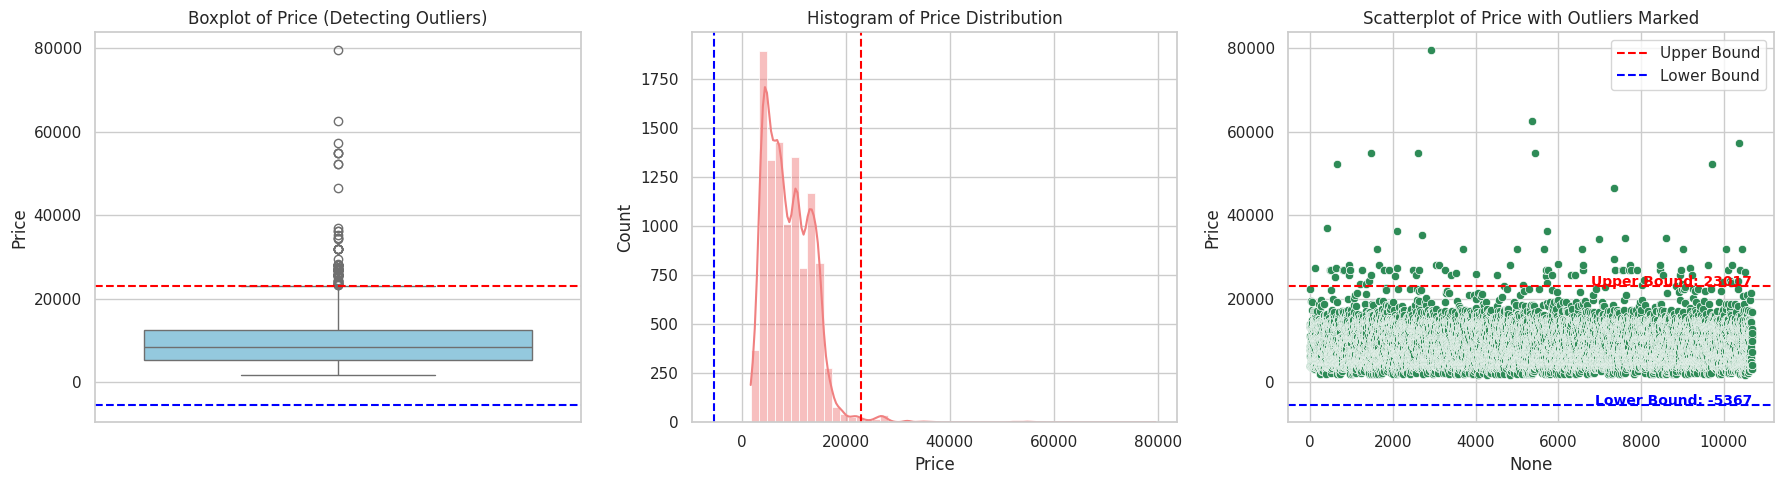

In [321]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Boxplot to show outliers
sns.boxplot(y=data['Price'], ax=axes[0], color='skyblue')
axes[0].set_title("Boxplot of Price (Detecting Outliers)")
axes[0].axhline(y=upper_bound, color='red', linestyle='dashed', label="Upper Bound")
axes[0].axhline(y=lower_bound, color='blue', linestyle='dashed', label="Lower Bound")

# Histogram to see price distribution
sns.histplot(data['Price'], bins=50, kde=True, ax=axes[1], color='lightcoral')
axes[1].set_title("Histogram of Price Distribution")
axes[1].axvline(x=upper_bound, color='red', linestyle='dashed', label="Upper Bound")
axes[1].axvline(x=lower_bound, color='blue', linestyle='dashed', label="Lower Bound")

# Scatterplot to identify outliers visually
sns.scatterplot(x=data.index, y=data['Price'], ax=axes[2], color='seagreen')
axes[2].axhline(y=upper_bound, color='red', linestyle='dashed', label="Upper Bound")
axes[2].axhline(y=lower_bound, color='blue', linestyle='dashed', label="Lower Bound")
# Annotate upper and lower bounds in scatterplot
axes[2].text(len(data) - 1, upper_bound, f'Upper Bound: {upper_bound:.0f}',
             color='red', ha='right', fontsize=10, fontweight='bold')
axes[2].text(len(data) - 1, lower_bound, f'Lower Bound: {lower_bound:.0f}',
             color='blue', ha='right', fontsize=10, fontweight='bold')
# Annotate outliers
for idx, row in outliers.iterrows():
    ax.annotate(f"{row['Price']:.0f}",
                     (idx, row['Price']),
                     textcoords="offset points",
                     xytext=(0,10), ha='center',
                     fontsize=9, color='red',
                     arrowprops=dict(arrowstyle="->", color='red'))
axes[2].legend()
axes[2].set_title("Scatterplot of Price with Outliers Marked")

plt.tight_layout()
plt.show()


In [322]:
# Calculate the number of outliers in the 'Price' column

len(outliers)

94

Feature Selection Using Mutual Information to Identify Top Predictive Features for 'Price'


🔹 Top Features based on Mutual Information:
 Duration_total_mins     1.773090
Airline                 1.316164
Total_Stops             0.781270
Is_Peak_Season          0.271176
Is_Holiday_Season       0.090498
ATF_Price_INR           0.075191
Days_Until_Departure    0.009596
Cabin_Class             0.000000
dtype: float64


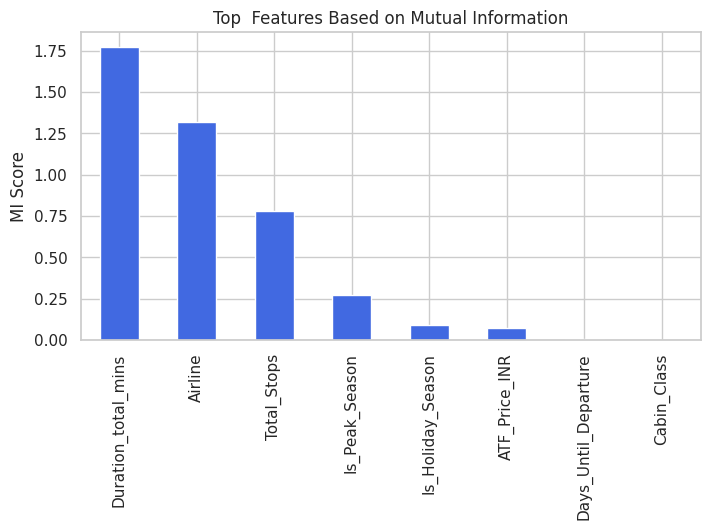

In [323]:
from sklearn.feature_selection import mutual_info_regression
# Separate independent and target variables
#X = data[['Airline','Days_Until_Departure','Fuel_Price','Is_Peak_Season','Cabin_Class','Is_Holiday_Season','Duration_total_mins','Total_Stops']]  # Corrected column name
# Correct the column name if necessary or replace with the actual name from data.columns
X = data[['Airline','Days_Until_Departure','ATF_Price_INR','Is_Peak_Season','Cabin_Class','Is_Holiday_Season','Duration_total_mins','Total_Stops']]
y = data['Price']  # Target variable

### 1. Mutual Information
mi = mutual_info_regression(X, y)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print("🔹 Top Features based on Mutual Information:\n", mi_series.head(10))

# Plot Mutual Information Scores
plt.figure(figsize=(8, 4))
mi_series.head(10).plot(kind='bar', color='royalblue')
plt.title("Top  Features Based on Mutual Information")
plt.ylabel("MI Score")
plt.show()

Calculate and Visualize Mutual Information Between Features to Identify Relationships


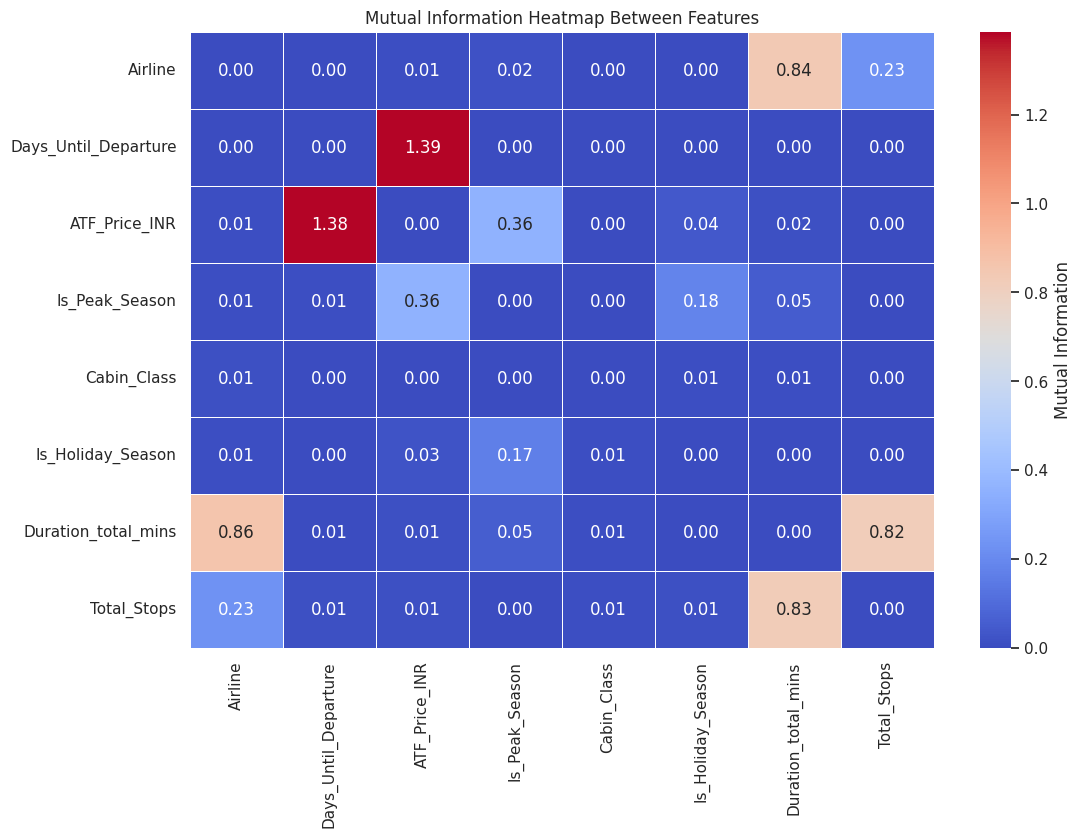

In [325]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

# Assuming 'data' is your DataFrame with the necessary columns
# Select the features you want to include in the analysis
#X = data[['Airline','Days_Until_Departure','Fuel_Price','Is_Peak_Season','Cabin_Class','Is_Holiday_Season','Duration_total_mins','Total_Stops']]
# Correct the column name if necessary or replace with the actual name from data.columns
X = data[['Airline','Days_Until_Departure','ATF_Price_INR','Is_Peak_Season','Cabin_Class','Is_Holiday_Season','Duration_total_mins','Total_Stops']]
# To handle categorical variables, let's first one-hot encode them
X_encoded = pd.get_dummies(X, drop_first=True)

# Create a matrix to store mutual information values
mi_matrix = np.zeros((X_encoded.shape[1], X_encoded.shape[1]))

# Compute mutual information between each pair of features
for i in range(X_encoded.shape[1]):
    for j in range(X_encoded.shape[1]):
        if i != j:
            # Calculate mutual information between feature i and feature j
            mi_matrix[i, j] = mutual_info_regression(X_encoded[[X_encoded.columns[i]]], X_encoded[X_encoded.columns[j]])[0]

# Convert the matrix to a DataFrame for better readability
mi_df = pd.DataFrame(mi_matrix, columns=X_encoded.columns, index=X_encoded.columns)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(mi_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Mutual Information'})
plt.title("Mutual Information Heatmap Between Features")
plt.show()


Perform Recursive Feature Elimination (RFE) to Select Top Features and Visualize Rankings


🔹 RFE Feature Rankings (Lower is better):
 Airline                 1
Is_Peak_Season          1
Total_Stops             1
Is_Holiday_Season       2
Cabin_Class             3
Days_Until_Departure    4
Duration_total_mins     5
ATF_Price_INR           6
dtype: int64

🔹 Top Features Selected by RFE:
 Index(['Airline', 'Is_Peak_Season', 'Total_Stops'], dtype='object')


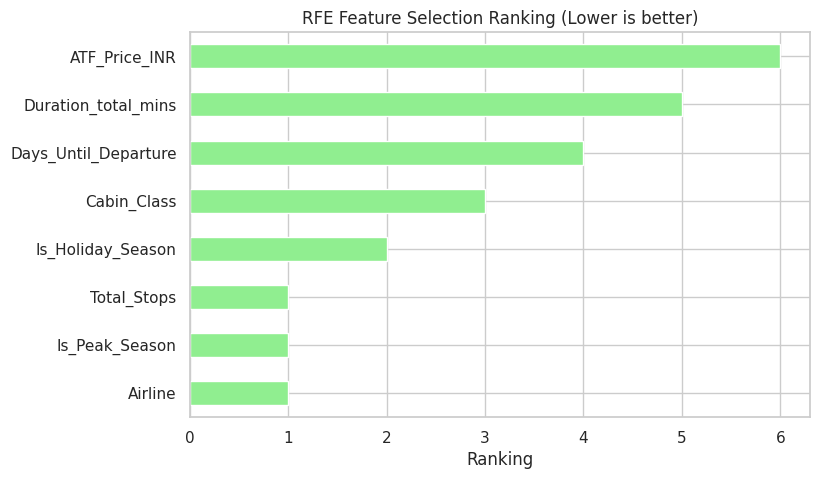

In [326]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd

# Initialize model
model = LinearRegression()

# Apply RFE to select top 3 features
rfe = RFE(model, n_features_to_select=3)
rfe.fit(X, y)

# Get selected features
selected_features_rfe = X.columns[rfe.support_]

# Get feature rankings
feature_rankings = pd.Series(rfe.ranking_, index=X.columns).sort_values()

# Print RFE rankings
print("🔹 RFE Feature Rankings (Lower is better):\n", feature_rankings)

# Print top selected features
print("\n🔹 Top Features Selected by RFE:\n", selected_features_rfe)

# Plot RFE Rankings
plt.figure(figsize=(8, 5))
feature_rankings.plot(kind='barh', color='lightgreen')
plt.title("RFE Feature Selection Ranking (Lower is better)")
plt.xlabel("Ranking")
plt.show()


Feature Importance Evaluation Using Random Forest Model


Top Features based on Random Forest Importance:
 Duration_total_mins     0.538119
Airline                 0.170968
ATF_Price_INR           0.117848
Days_Until_Departure    0.091557
Cabin_Class             0.024582
Is_Holiday_Season       0.020773
Total_Stops             0.020129
Is_Peak_Season          0.016023
dtype: float64


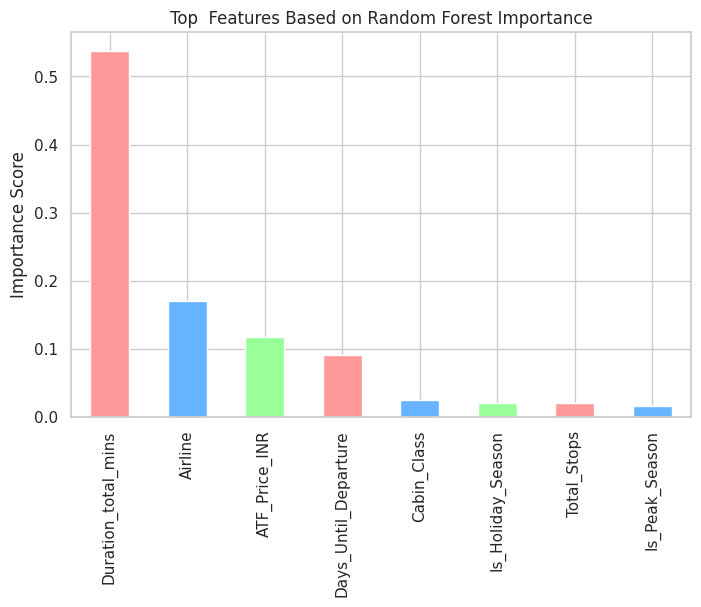

In [327]:
from sklearn.ensemble import RandomForestRegressor  # Import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
### 3. Feature Importance using Random Forest
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X, y)
feature_importance = pd.Series(random_forest_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top Features based on Random Forest Importance:\n",feature_importance)

# Plot Feature Importances
plt.figure(figsize=(8, 5))
feature_importance.plot(kind='bar', color=['#ff9999', '#66b3ff', '#99ff99'])
plt.title("Top  Features Based on Random Forest Importance")
plt.ylabel("Importance Score")
plt.show()

In [328]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [329]:
#X_train={'Airline','Duration_total_mins','Total_Stops'}
#y_train={'Price'}
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [330]:
#ml_model= RandomForestRegressor(n_estimators=100, random_state=42)
#ml_model.fit(X_train, y_train)

In [331]:
#y_pred = ml_model.predict(X_test)
#y_pred

In [332]:
#from sklearn import metrics
#metrics.r2_score(y_test, y_pred)

Linear Regression

In [333]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Assuming 'data' is a preloaded DataFrame
X = data[['Airline', 'Duration_total_mins', 'Total_Stops']]
#X = data[['Airline', 'Is_Peak_Season', 'Total_Stops']]
y = data['Price']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Initialize and train Ridge Regression model
# Change this line to initialize a Ridge model instead of LinearRegression
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Predictions
# Change this line to use the 'ridge_model' for predictions
y_pred = ridge_model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R^2 Score: {r2:.4f}")

Mean Absolute Error: 2230.82
Mean Squared Error: 10490129.45
Root Mean Squared Error: 3238.85
R^2 Score: 0.4755


Decision Tree

In [334]:
from sklearn.tree import DecisionTreeRegressor  # For regression tasks
# from sklearn.tree import DecisionTreeClassifier  # For classification tasks
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
X = data[['Airline', 'Duration_total_mins', 'Total_Stops']]
X = data[['Airline','Is_Peak_Season','Total_Stops']]
  # Features
y = data['Price']
# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Step 5: Train the Decision Tree model
model = DecisionTreeRegressor(max_depth=5,random_state=123)  # For regression tasks
# model = DecisionTreeClassifier(random_state=42)  # For classification tasks
model.fit(X_train, y_train)

# Step 6: Make predictions
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
#metrics.r2_score(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

# Step 7: Evaluate the model
#print("Decision Tree Performance:")
#print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")  # Mean Absolute Error
#print(f"R² Score: {r2_score(y_test, y_pred):.2f}")  # R-squared (for regression tasks)
# For classification tasks, use accuracy_score, precision_score, recall_score, etc.

# Step 8: Visualize the Decision Tree (optional)
#from sklearn.tree import plot_tree
#import matplotlib.pyplot as plt

#plt.figure(figsize=(12, 8))
#plot_tree(model, filled=True, feature_names=X.columns, rounded=True)
#plt.show()

Mean Absolute Error: 1995.3458777852036
Mean Squared Error: 8692010.126987806
Root Mean Squared Error: 2948.2215193210645
R^2 Score: 0.5692816516698188


Random Forest

In [335]:
X = data[['Airline','Is_Peak_Season','Total_Stops']]
  # Features
y = data['Price']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
rf_model = RandomForestRegressor(n_estimators=1000, random_state=123)


rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model's performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
#metrics.r2_score(y_test, y_pred)
# Print evaluation metrics
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

Mean Absolute Error: 1929.8400943086701
Mean Squared Error: 8401672.565324437
Root Mean Squared Error: 2898.5638798074533
R^2 Score: 0.5836688547667848


XG Boost

In [336]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor  # For regression tasks
# from xgboost import XGBClassifier  # For classification tasks
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
X = data[['Airline','Is_Peak_Season','Total_Stops']]# Features
y = data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
model = XGBRegressor(random_state=123)  # For regression tasks
# model = XGBClassifier(random_state=42)  # For classification tasks
model.fit(X_train, y_train)

# Step 6: Make predictions
y_pred = model.predict(X_test)
# Evaluate the model's performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
#metrics.r2_score(y_test, y_pred)
# Print evaluation metrics
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')




Mean Absolute Error: 1929.9344482421875
Mean Squared Error: 8401010.0
Root Mean Squared Error: 2898.449585554318
R^2 Score: 0.5837016701698303
